In [1]:
import pandas as pd
import os

In [2]:
topic = 'feminism'
scheme = 'EIII_v2'

path = os.getcwd()
clean_path = f'{path}/clean'
NN_path = f'{path}/NN/{topic}/{scheme}'

train_file = f'{path}/train/labeled_{topic}_train.csv'
test_file = f'{path}/test/labeled_{topic}_test.csv'

os.makedirs(NN_path, exist_ok=True)
os.makedirs(f'{clean_path}/train', exist_ok=True)
os.makedirs(f'{clean_path}/test', exist_ok=True)

NN_path

'/media/rinnely/Archer1/ENES/Stance/Clasificador/NN/feminism/EIII_v2'

In [ ]:
train = pd.read_csv(train_file)

In [ ]:
train

In [ ]:
train = train[[f'Label_{scheme}', 'Tweet']]
train.columns = ['Label', 'Tweet']

In [ ]:
train.head()

In [ ]:
train.Label.unique()

In [ ]:
train = train.query('Label != 0')
train.Label.unique()

In [ ]:
train.groupby('Label').count()

In [ ]:
test = pd.read_csv(test_file)
test.head()

In [ ]:
test = test[['Stance', 'Tweet']]
test.Stance.unique()

In [ ]:
test['Stance']= test.Stance.replace({'FAVOR':1, 'AGAINST':-1, 'NONE':0})
test = test.query('Stance != 0')
test.Stance.unique()

In [ ]:
test.columns = ['Label', 'Tweet']
test.groupby('Label').count()

In [ ]:
train.shape, test.shape

# clean data

In [32]:
import sys
sys.path.insert(0, '/media/rinnely/Archer1/ENES/Stance')
import cleandata as cd

In [ ]:
train = cd.cleanData(train.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')
test = cd.cleanData(test.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')

In [ ]:
train = train.dropna(axis=0)

# save data

In [ ]:
train.to_csv(f'{clean_path}/train/clean_{topic}_{scheme}_train.csv', index=False)
test.to_csv(f'{clean_path}/test/clean_{topic}_{scheme}_test.csv', index=False)

# read data

In [3]:
train = pd.read_csv(f'{clean_path}/train/clean_{topic}_{scheme}_train.csv')
test = pd.read_csv(f'{clean_path}/test/clean_{topic}_{scheme}_test.csv')

In [ ]:
train['Label'].value_counts().plot.pie(legend=True)

In [ ]:
test['Label'].value_counts().plot.pie(legend=True)

In [ ]:
train['Label'].value_counts().plot.bar(legend=True)

In [ ]:
test['Label'].value_counts().plot.bar(legend=True)

In [ ]:
train

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
train = train.dropna(axis=0)

In [ ]:
train.info()

# Training

In [4]:
from fastai.text import *

In [5]:
data_lm = (TextList.from_df(train, NN_path, cols='Tweet')
          .split_by_rand_pct(0.2)
          .label_for_lm() # this does the tokenization and numericalization
          .databunch())
data_clas = TextClasDataBunch.from_df(NN_path, train_df=train, 
                                      valid_df=test, 
                                      vocab=data_lm.vocab, 
                                      text_cols = 'Tweet', 
                                      label_cols = 'Label',
                                      bs=32)
data_lm.save(f'data_lm_{topic}_{scheme}')
data_clas.save(f'data_clas_{topic}_{scheme}')

/home/rinnely/anaconda3/lib/python3.8/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [6]:
#learn = ftxt.language_model_learner(data_lm, arch=ftxt.AWD_LSTM, drop_mult=.2)
learn_lm = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 5.25E-02


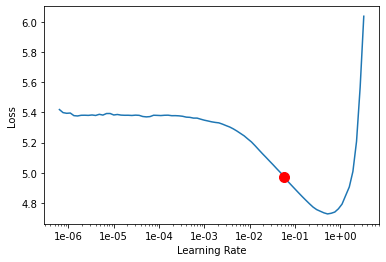

In [7]:
learn_lm.lr_find(); learn_lm.recorder.plot(suggestion=True)

In [8]:
learn_lm.fit_one_cycle(3,5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.505734,3.640357,0.302723,00:05
1,3.936722,3.491022,0.318795,00:05
2,3.572905,3.449914,0.327009,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 9.12E-04


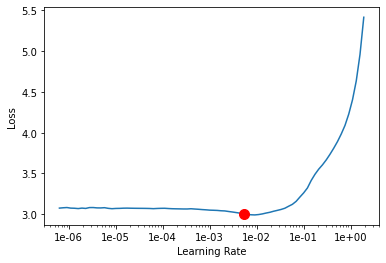

In [9]:
learn_lm.unfreeze()
learn_lm.lr_find(); learn_lm.recorder.plot(suggestion=True)

In [10]:
learn_lm.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,3.053797,3.405267,0.333884,00:07
1,2.976342,3.380317,0.336250,00:07
2,2.900523,3.374287,0.337187,00:07


In [11]:
learn_lm.save_encoder(f'{topic}_ml_encoder_v1')
learn_lm.save(f'{topic}_model_v1')

In [ ]:
learn_lm.load_encoder(f'{topic}_ml_encoder_v1');
learn_lm.load(f'{topic}_model_v1');

In [12]:
from sklearn.metrics import f1_score

@np_func #converts torch tesnsor as numpy array
def f1_macro(inp, targ): return f1_score(targ, np.argmax(inp, axis=1), average='macro')

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(f'{topic}_ml_encoder_v1')
learn.metrics=[f1_macro]
learn.freeze()

In [13]:
learn.save('learner-1stage')

In [ ]:
learn.load('learner-1stage');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 5.25E-02


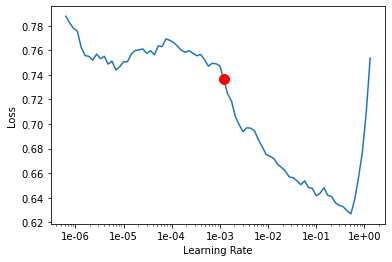

In [14]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [15]:
learn.fit_one_cycle(5,1e-3,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.591188,0.661324,0.547021,00:05
1,0.528732,0.636901,0.558412,00:05
2,0.503715,0.631997,0.543738,00:05
3,0.487841,0.625401,0.572628,00:05
4,0.464960,0.621470,0.547170,00:05


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [16]:
learn.save('learner-2stage')

In [ ]:
learn.load('learner-2stage');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 5.75E-05


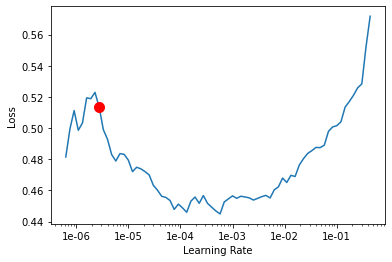

In [18]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(2,moms=(0.8, 0.7))

In [ ]:
learn.save('learner-3stage')

In [ ]:
learn.load('learner-3stage');

In [ ]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 4.79E-05


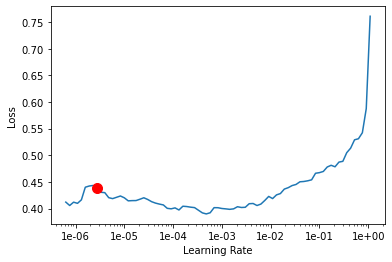

In [22]:
learn.freeze_to(-2)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [23]:
learn.fit_one_cycle(3,moms=(0.8, 0.7));

epoch,train_loss,valid_loss,f1_macro,time
0,0.435209,0.639021,0.559175,00:07
1,0.404080,0.636552,0.591948,00:06
2,0.400186,0.648968,0.582748,00:06


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
learn.save('learner-stage-freeze-2')

In [ ]:
learn.save('learner-stage-freeze-2')

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 1.45E-04


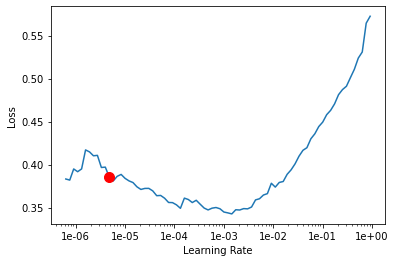

In [25]:
learn.freeze_to(-3)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [26]:
learn.fit_one_cycle(1, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.389716,0.630295,0.590364,00:11


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
learn.save('learner-stage-freeze-3')

In [ ]:
learn.load('learner-stage-freeze-3');

In [ ]:
torch.cuda.empty_cache()

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


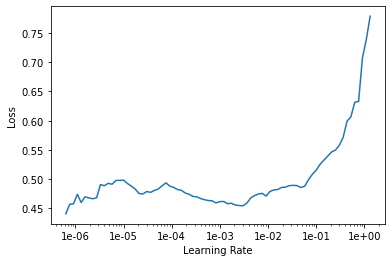

In [19]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [28]:
learn.fit_one_cycle(1, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.358749,0.668023,0.602966,00:10


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
learn.fit_one_cycle(1, moms=(0.8, 0.7))

In [33]:
data = pd.read_csv(train_file)
data.head()
data['NNAgainst'] = ''
data['NNFavor'] = ''
data.head()
data = cd.cleanData(data.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')
data.head()

,id,Tweet,Label_EIII_v2,Stance_EIII_v2,NNAgainst,NNFavor
0,1343345719374188544,even though this person is basically using fem...,0,Uknown,,
1,1343345503434649600,"This... Opinion | During the Coronavirus, Femi...",0,Uknown,,
2,1343345499278086144,So I am a mixed Black person and that has evol...,0,Uknown,,
3,1343345498862858240,"Bidisha, in Chapter 6 of The Fifty Shades of F...",0,Uknown,,
4,1343345262228631554,USER because of feminism. ;-) balls are a miso...,0,Uknown,,


In [34]:
from tqdm.notebook import tqdm, trange
import time 
for i in trange(data.shape[0]):
    #time.sleep(0.01)
    data.loc[i,'Tweet']
    result = learn.predict(data.loc[i,'Tweet'])
    r = result[2].numpy()
    data.loc[i,'NNAgainst'] = r[0]
    data.loc[i,'NNFavor'] = r[1]

  0%|          | 0/3574 [00:00<?, ?it/s]

In [35]:
data['NNPred'] = data[['NNFavor','NNAgainst']].apply(lambda x : 1 if x[0] >= 0.7 else( -1 if x[1] >= 0.8 else 0 ),axis=1)

In [ ]:
data

In [36]:
data.to_csv('/media/rinnely/Archer1/ENES/Stance/Clasificador/train/labeled_feminism_NNtrain.csv', index=False)

In [ ]:
learn.save('learner-stage-unfreeze-62')

In [ ]:
learn.load('learner-stage-unfreeze-62');

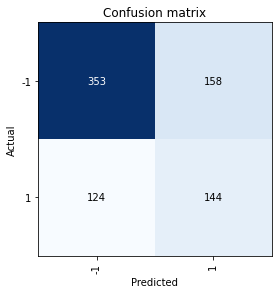

In [29]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = TextClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [ ]:
preds

In [37]:
learn.save('learner-final')